# Modeling and Simulation in Python

Chapter 5: Design

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the functions defined in the `modsim` module.

In [32]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### SIR implementation

We'll use a `State` object to represent the number or fraction of people in each compartment.

In [33]:
init = State(S=89, I=1, R=0)
init

,value
S,89
I,1
R,0


To convert from number of people to fractions, we divide through by the total.

In [34]:
init /= np.sum(init)
init

,value
S,0.988889
I,0.011111
R,0.000000


`make_system` creates a `System` object with the given parameters.

In [35]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [36]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)

The update function takes the state during the current time step and returns the state during the next time step.

In [37]:
def update1(system, state):
    """Update the SIR model.
    
    system: System object
    state: StateVector (s, i, r)
    
    returns: StateVector (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

To run a single time step, we call it like this:

In [38]:
state = update1(sir, init)
state

,value
S,0.985226
I,0.011996
R,0.002778


Now we can run a simulation by calling the update function for each time step.

In [39]:
def run_simulation(system, update_func):
    state = system.init
    for i in range(system.t0, system.t_end):
        state = update_func(system, state)
    return state

The result is the state of the system at `t_end`

In [40]:
run_simulation(sir, update1)

,value
S,0.520568
I,0.000666
R,0.478766


### Using Series objects

If we want to store the state of the system at each time step, we can use one `TimeSeries` object for each state variable.

In [41]:
def run_simulation(system, update_func):
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    S[0], I[0], R[0] = state
    
    for i in range(sir.t0, sir.t_end):
        state = update_func(system, state)
        S[i+1], I[i+1], R[i+1] = state
    
    system.S = S
    system.I = I
    system.R = R

Here's how we call it.

In [42]:
sir = make_system(beta, gamma)
run_simulation(sir, update1)

And then we can plot the results.

In [43]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

Saving figure to file chap05-fig01.pdf


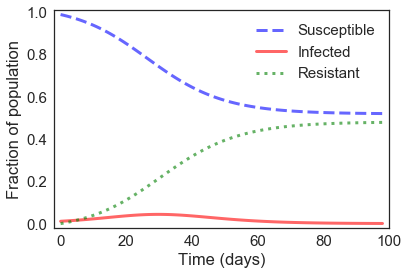

In [44]:
plot_results(sir.S, sir.I, sir.R)
savefig('chap05-fig01.pdf')

### Using a DataFrame

Instead of making three `TimeSeries` objects, we can use one `DataFrame`.

We have to use `loc` to indicate which row we want to assign the results to.  But then Pandas does the right thing, matching up the state variables with the columns of the `DataFrame`.

In [45]:
def run_simulation(system, update_func):
    df = DataFrame(columns=['S', 'I', 'R'])
    df.loc[system.t0] = system.init
    
    for i in range(system.t0, system.t_end):
        df.loc[i+1] = update_func(system, df.loc[i])
    
    system.results = df

Here's how we run it, and what the result looks like.

In [46]:
sir = make_system(beta, gamma)
run_simulation(sir, update1)
sir.results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


We can extract the results and plot them.

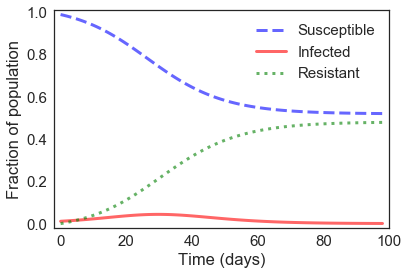

In [47]:
df = sir.results
plot_results(df.S, df.I, df.R)

### Metrics

Given the results, we can compute metrics that measure whatever we are interested in, like the total number of sick students, for example.

In [18]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    df = system.results
    return df.S[system.t0] - df.S[system.t_end]

Here's an example.|

In [19]:
sir.beta = 0.333
sir.gamma = 0.25
run_simulation(sir, update1)
print(sir.beta, sir.gamma, calc_total_infected(sir))

0.333 0.25 0.467162931836


**Exercise:** Write functions that take a `System` object as a parameter, extract the `results` object from it, and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.argmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

In [19]:
# Solution

def fraction_sick_at_peak(system):
    df = system.results
    return df.I.max()

In [20]:
# Solution

fraction_sick_at_peak(sir)

0.043536202687592354

In [21]:
# Solution

def time_of_peak(system):
    df = system.results
    return df.I.argmax()

In [22]:
# Solution

time_of_peak(sir)

30

In [23]:
# Solution

def sick_at_end(system):
    df = system.results
    return df.I[system.t_end]

In [24]:
# Solution

sick_at_end(sir)

0.00067419431560344738

### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [20]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [21]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

sir = make_system(beta, gamma)
sir.beta, sir.gamma

(0.3333333333333333, 0.25)

And run the model without immunization.

In [22]:
run_simulation(sir, update1)
calc_total_infected(sir)

0.46832081102878098

Now with 10% immunization.

In [23]:
sir2 = make_system(beta, gamma)
add_immunization(sir2, 0.1)
run_simulation(sir2, update1)
calc_total_infected(sir2)

0.30650802853979753

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file chap05-fig02.pdf


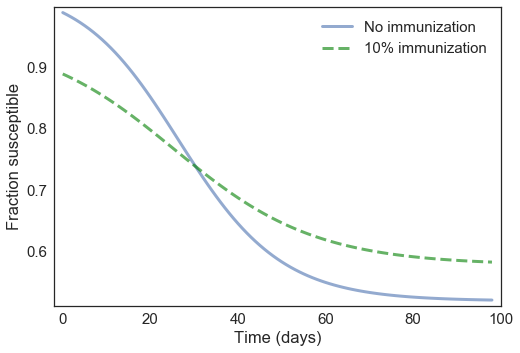

In [24]:
plot(sir.results.S, '-', label='No immunization')
plot(sir2.results.S, 'g--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('chap05-fig02.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [25]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    sir = make_system(beta, gamma)
    add_immunization(sir, fraction)
    run_simulation(sir, update1)
    print(fraction, calc_total_infected(sir))

0.0 0.468320811029
0.1 0.30650802854
0.2 0.161365457006
0.3 0.0728155898425
0.4 0.035520216753
0.5 0.0196887157825
0.6 0.0116220579983
0.7 0.00683873780062
0.8 0.00369649625371
0.9 0.00148153267227
1.0 -0.000161212109412


This function does the same thing and stores the results in a `Sweep` object.

In [48]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = Sweep()
    for fraction in immunize_array:
        sir = make_system(beta, gamma)
        add_immunization(sir, fraction)
        run_simulation(sir, update1)
        sweep[fraction] = calc_total_infected(sir)
    return sweep

Here's how we run it.

In [49]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

And here's what the results look like.

Saving figure to file chap05-fig03.pdf


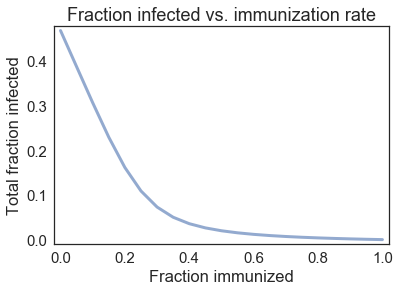

In [50]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('chap05-fig03.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Hand washing

To model the effect of a hand-washing campaign, we'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function).

In [51]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [52]:
spending = linspace(0, 1200, 21)
spending

array([    0.,    60.,   120.,   180.,   240.,   300.,   360.,   420.,
         480.,   540.,   600.,   660.,   720.,   780.,   840.,   900.,
         960.,  1020.,  1080.,  1140.,  1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [53]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

Saving figure to file chap05-fig04.pdf


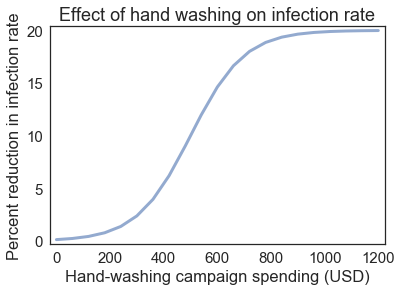

In [54]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

savefig('chap05-fig04.pdf')

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [55]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [56]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [57]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    sir = make_system(beta, gamma)
    add_hand_washing(sir, spending)
    run_simulation(sir, update1)
    print(spending, sir.beta, calc_total_infected(sir))

0.0 0.332887143272 0.466770231236
100.0 0.332134252669 0.464141650401
200.0 0.330171608455 0.457217006313
300.0 0.325386471865 0.439887202912
400.0 0.315403905242 0.401630646271
500.0 0.3 0.33703425949
600.0 0.284596094758 0.267317030568
700.0 0.274613528135 0.22184699046
800.0 0.269828391545 0.200791598416
900.0 0.267865747331 0.192392183393
1000.0 0.267112856728 0.189213207818
1100.0 0.26683150821 0.18803175228
1200.0 0.266727403413 0.187595503995


Here's a function that sweeps a range of spending and stores the results in a `Sweep` object.

In [62]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = Sweep()
    for spending in spending_array:
        sir = make_system(beta, gamma)
        add_hand_washing(sir, spending)
        run_simulation(sir, update1)
        sweep[spending] = calc_total_infected(sir)
    return sweep

Here's how we run it.

In [66]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

And here's what it looks like.

Saving figure to file chap05-fig05.pdf


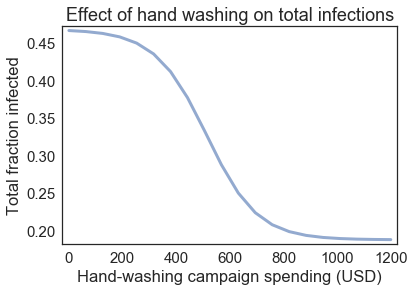

In [67]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('chap05-fig05.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [68]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = arange(max_doses+1)
max_doses

12

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [69]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    sir = make_system(beta, gamma)
    add_immunization(sir, fraction)
    add_hand_washing(sir, spending)
    
    run_simulation(sir, update1)
    print(doses, sir.init.S, sir.beta, calc_total_infected(sir))

0 0.988888888889 0.266727403413 0.187595503995
1 0.977777777778 0.26683150821 0.174580718826
2 0.966666666667 0.267112856728 0.162909838349
3 0.955555555556 0.267865747331 0.153508349478
4 0.944444444444 0.269828391545 0.148565092315
5 0.933333333333 0.274613528135 0.152945950611
6 0.922222222222 0.284596094758 0.174964415024
7 0.911111111111 0.3 0.217343161684
8 0.9 0.315403905242 0.259071044488
9 0.888888888889 0.325386471865 0.278402884103
10 0.877777777778 0.330171608455 0.277914534623
11 0.866666666667 0.332134252669 0.267357496693
12 0.855555555556 0.332887143272 0.252796945636


The following function wraps that loop and stores the results in a `Sweep` object.

In [46]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = Sweep()
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        sir = make_system(beta, gamma)
        add_immunization(sir, fraction)
        add_hand_washing(sir, spending)
        
        run_simulation(sir, update1)
        sweep[doses] = calc_total_infected(sir)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [47]:
infected_sweep = sweep_doses(dose_array)

And plot the results.

Saving figure to file chap05-fig06.pdf


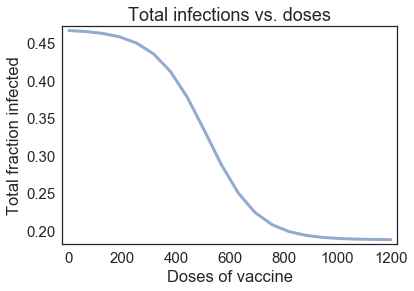

In [70]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('chap05-fig06.pdf')

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** How to model quarantine?

In [49]:
# Solution

def quarantine(system, fraction):
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr